# Real Estate Price Prediction using Machine Learning

In [2]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

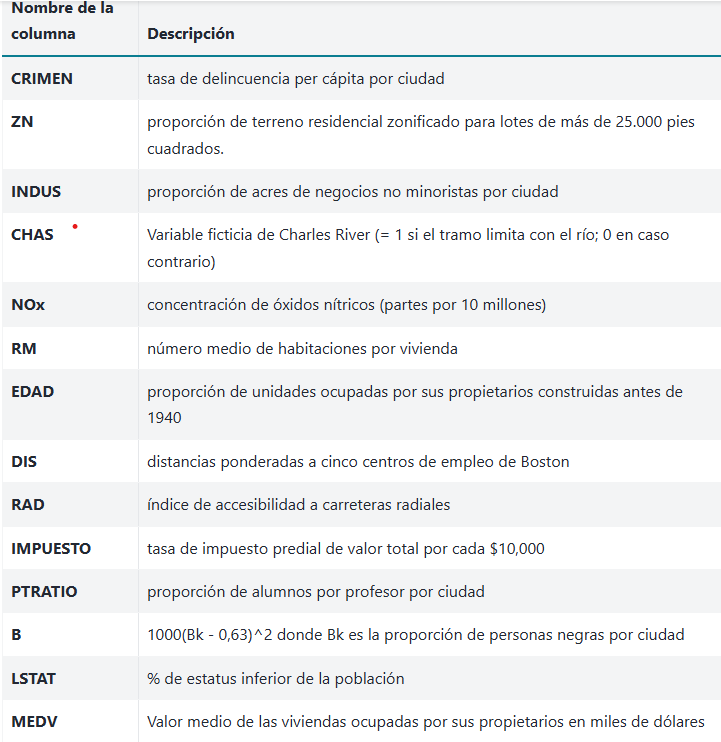

In [188]:
# Diccionario de Datos
from IPython.display import Image
display(Image(filename="../resources/images/data_dictionary.png"))

In [4]:
# Cargar la base de datos
file_path = "../data/raw/boston_raw.csv"
df = pd.read_csv(file_path, delimiter=',')
df.head(3)

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4


In [5]:
df.shape

(333, 15)

## 1. Análisis descriptivo y Preprocesamiento de datos

In [6]:
# Preprocesamiento: Se eliminan las columnas correspondientes
df = df.drop(columns=["ID"])
X = df.drop(columns=["medv"])
y = df["medv"]

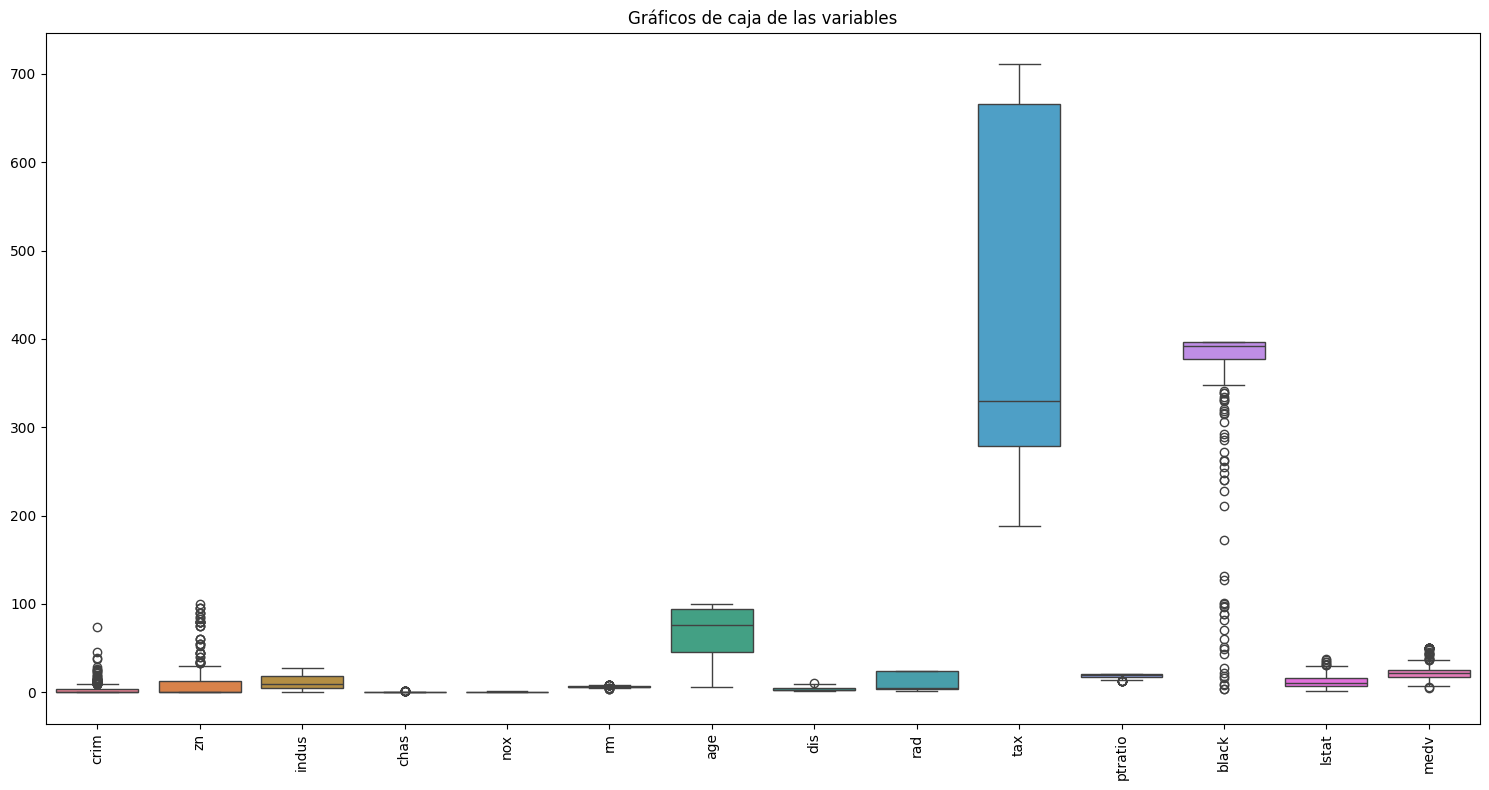

In [7]:
# Análisis descriptivo: Boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Gráficos de caja de las variables")
plt.tight_layout()
plt.show()

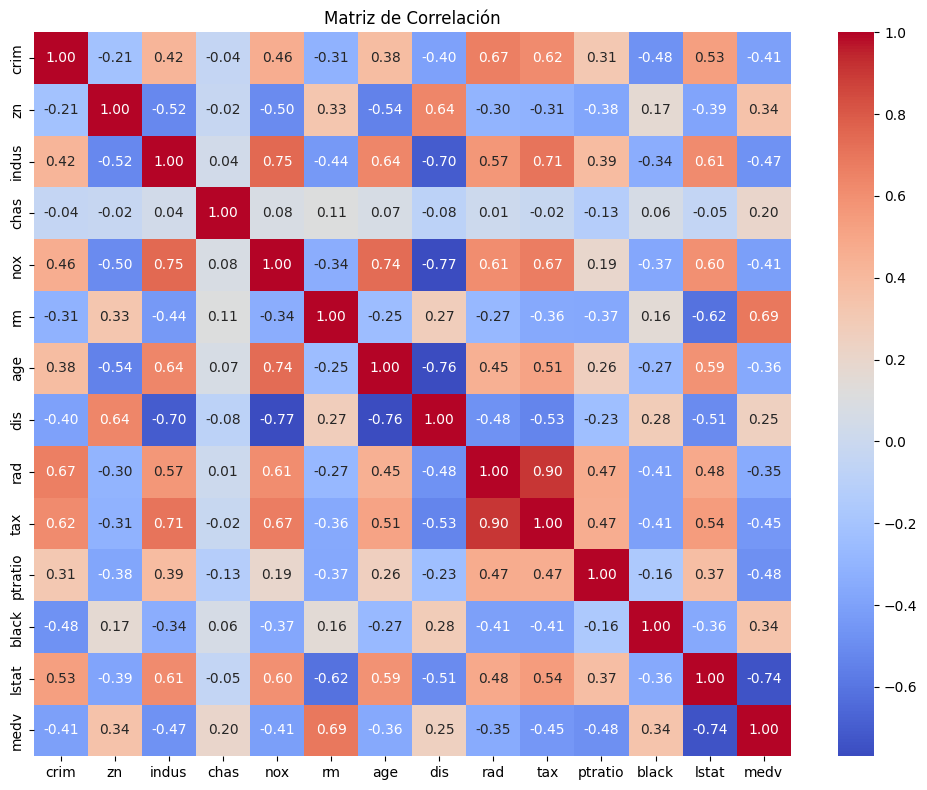

In [8]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

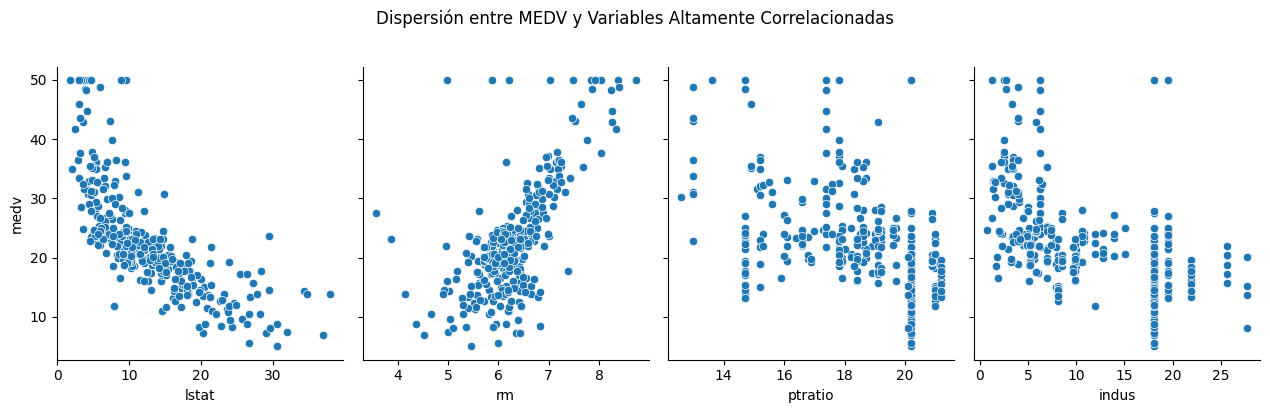

In [9]:
# Dispersión de las 4 más correlacionadas con MEDV
top_corr = df.corr()["medv"].abs().sort_values(ascending=False)[1:5].index
sns.pairplot(df, x_vars=top_corr, y_vars="medv", height=4, aspect=0.8, kind='scatter')
plt.suptitle("Dispersión entre MEDV y Variables Altamente Correlacionadas", y=1.02)
plt.tight_layout()
plt.show()

## 2. Modelo Básico de Árboles de Regresión

In [165]:
# División de datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [166]:
# Modelo de árbol
from sklearn.tree import DecisionTreeRegressor, plot_tree
modelo_arbol = DecisionTreeRegressor(random_state=42, max_depth=5)
modelo_arbol.fit(X_train, y_train)
y_pred = modelo_arbol.predict(X_test)

In [167]:
# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

metricas = pd.DataFrame({
    "Métrica": ["MAE", "RMSE", "MAPE", "R^2"],
    "Valor": [mae, rmse, mape, r2]
})

In [168]:
metricas

,Métrica,Valor
0,MAE,3.331584
1,RMSE,5.270059
2,MAPE,16.016025
3,R^2,0.691400


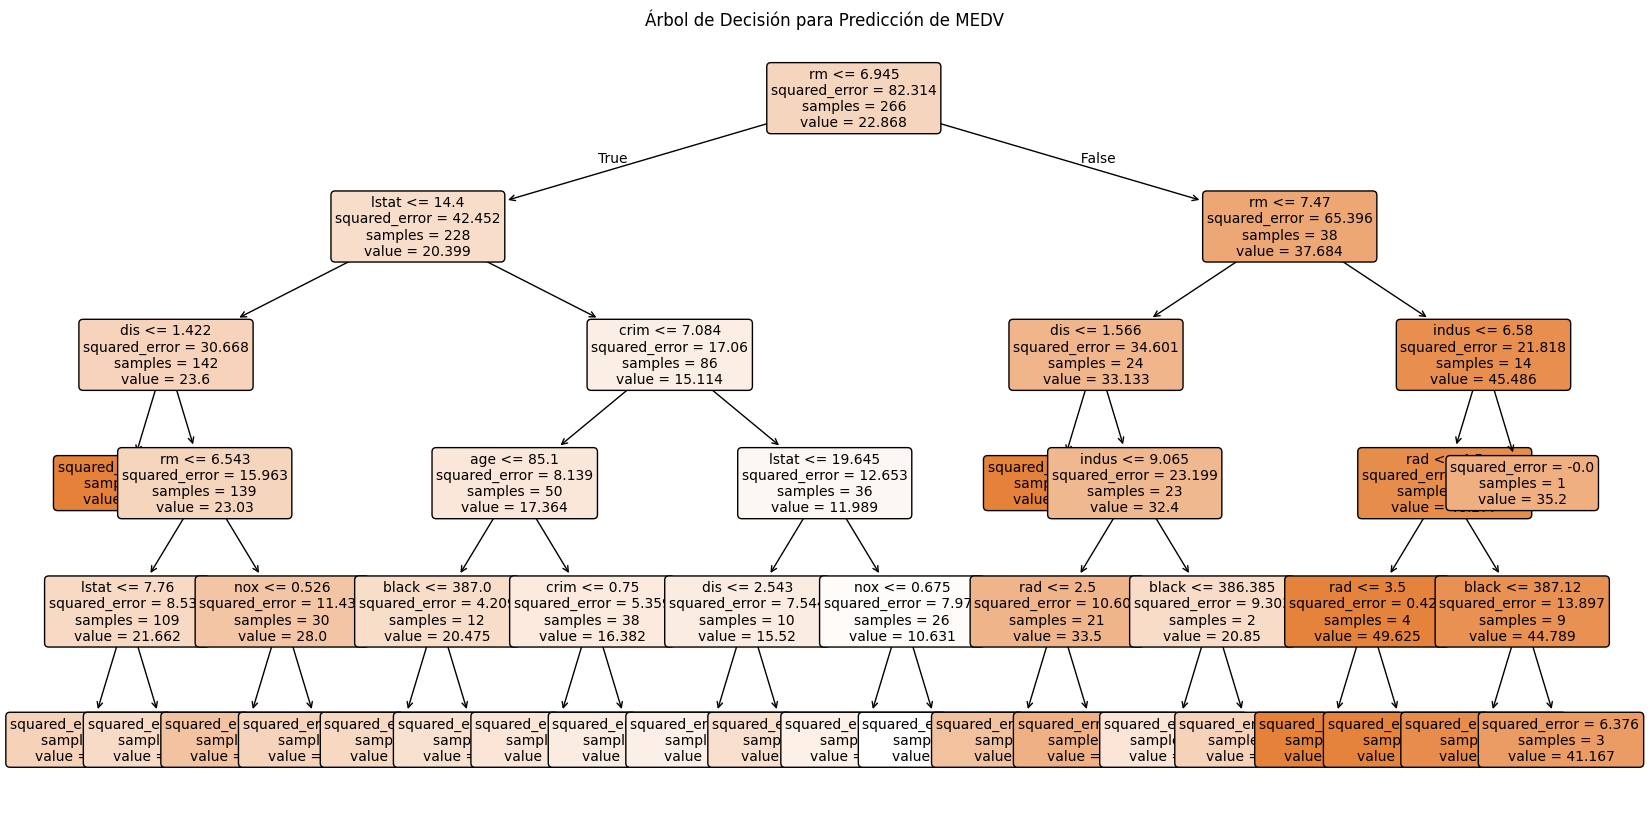

In [169]:
# Gráfico del árbol
plt.figure(figsize=(20, 10))
plot_tree(modelo_arbol, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title("Árbol de Decisión para Predicción de MEDV")
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_1876\2953478912.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df, x="Importancia", y="Variable", palette="viridis")


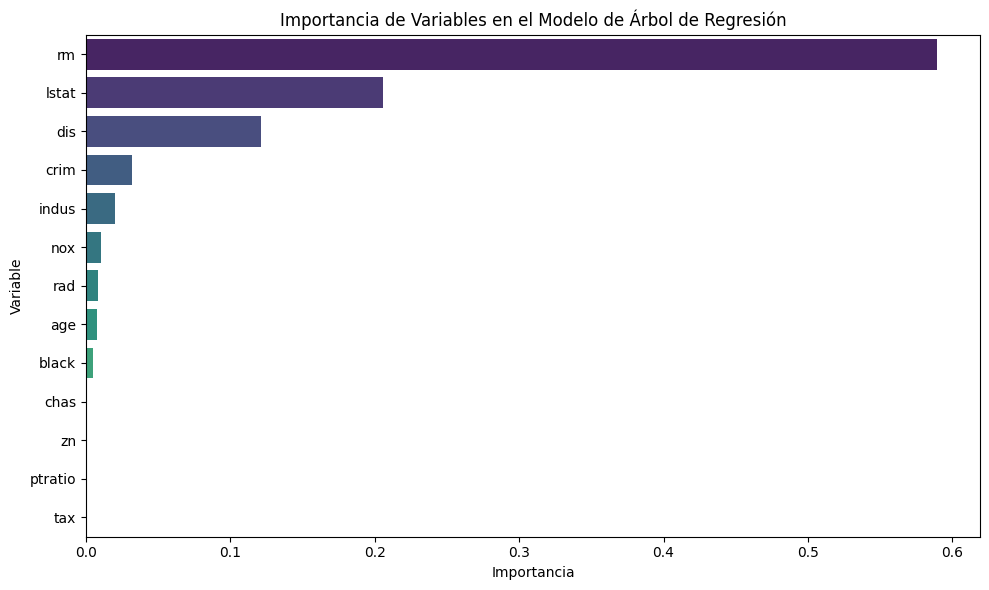

In [170]:
# Importancia de variables
importancias = modelo_arbol.feature_importances_
importancia_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_df, x="Importancia", y="Variable", palette="viridis")
plt.title("Importancia de Variables en el Modelo de Árbol de Regresión")
plt.tight_layout()
plt.show()

## 3. Modelo Optimizado de Árboles de Regresión

In [171]:
# Seleccionar las 5 variables más importantes
variables_importantes = importancia_df.head(5)["Variable"].tolist()
X_imp = df[variables_importantes]
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y, test_size=0.2, random_state=42)


In [173]:
# Definir el modelo base
modelo_base = DecisionTreeRegressor(random_state=42)

In [174]:
# Grid de hiperparámetros
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt"]
}

In [175]:
# GridSearchCV
grid_search = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

In [176]:
# Entrenamiento
grid_search.fit(X_train_imp, y_train_imp)
mejor_modelo = grid_search.best_estimator_
y_pred_final = mejor_modelo.predict(X_test_imp)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [177]:
# Evaluación
mae_final = mean_absolute_error(y_test_imp, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_imp, y_pred_final))
mape_final = np.mean(np.abs((y_test_imp - y_pred_final) / y_test_imp)) * 100
r2_final = r2_score(y_test_imp, y_pred_final)

metricas_finales = pd.DataFrame({
    "Métrica": ["MAE", "RMSE", "MAPE", "R^2"],
    "Valor": [mae_final, rmse_final, mape_final, r2_final]
})

metricas_finales

,Métrica,Valor
0,MAE,2.882846
1,RMSE,3.979557
2,MAPE,15.550549
3,R^2,0.824032


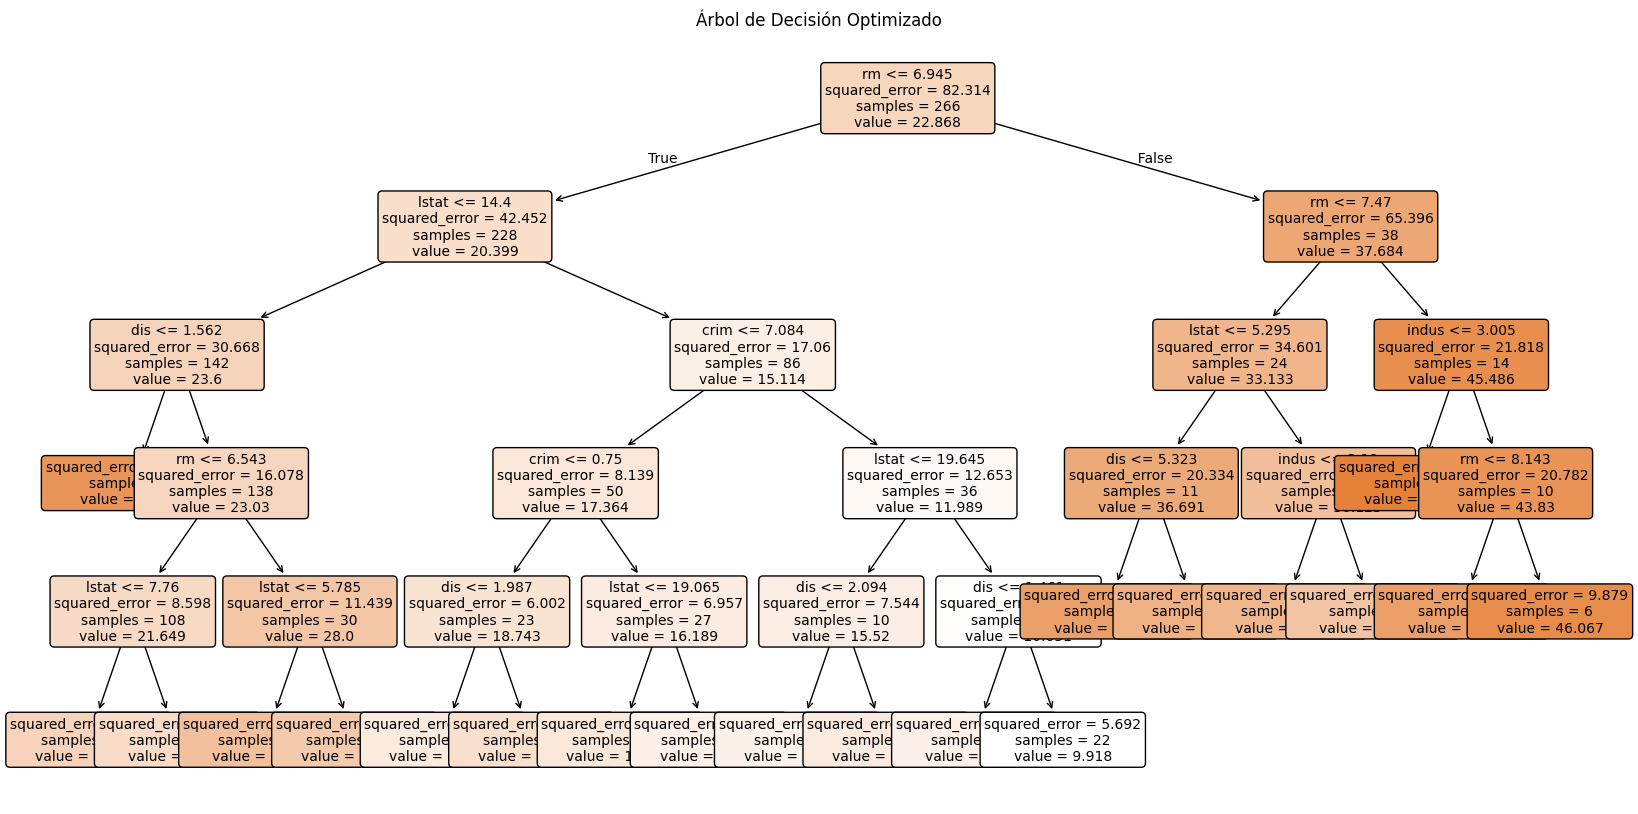

In [178]:
# Gráfico del árbol optimizado
plt.figure(figsize=(20, 10))
plot_tree(mejor_modelo, feature_names=X_train_imp.columns, filled=True, rounded=True, fontsize=10)
plt.title("Árbol de Decisión Optimizado")
plt.show()

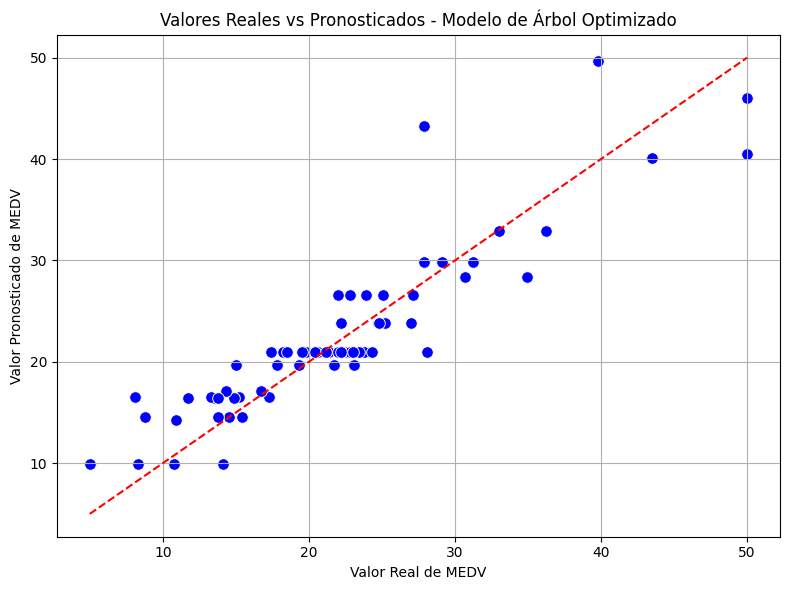

In [179]:
# Gráfico de dispersión de valores reales vs pronosticados
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_imp, y=y_pred_final, color='blue', edgecolor='w', s=70)
plt.plot([y_test_imp.min(), y_test_imp.max()], [y_test_imp.min(), y_test_imp.max()], 'r--')  # Línea de referencia 45°
plt.xlabel("Valor Real de MEDV")
plt.ylabel("Valor Pronosticado de MEDV")
plt.title("Valores Reales vs Pronosticados - Modelo de Árbol Optimizado")
plt.grid(True)
plt.tight_layout()
plt.show()

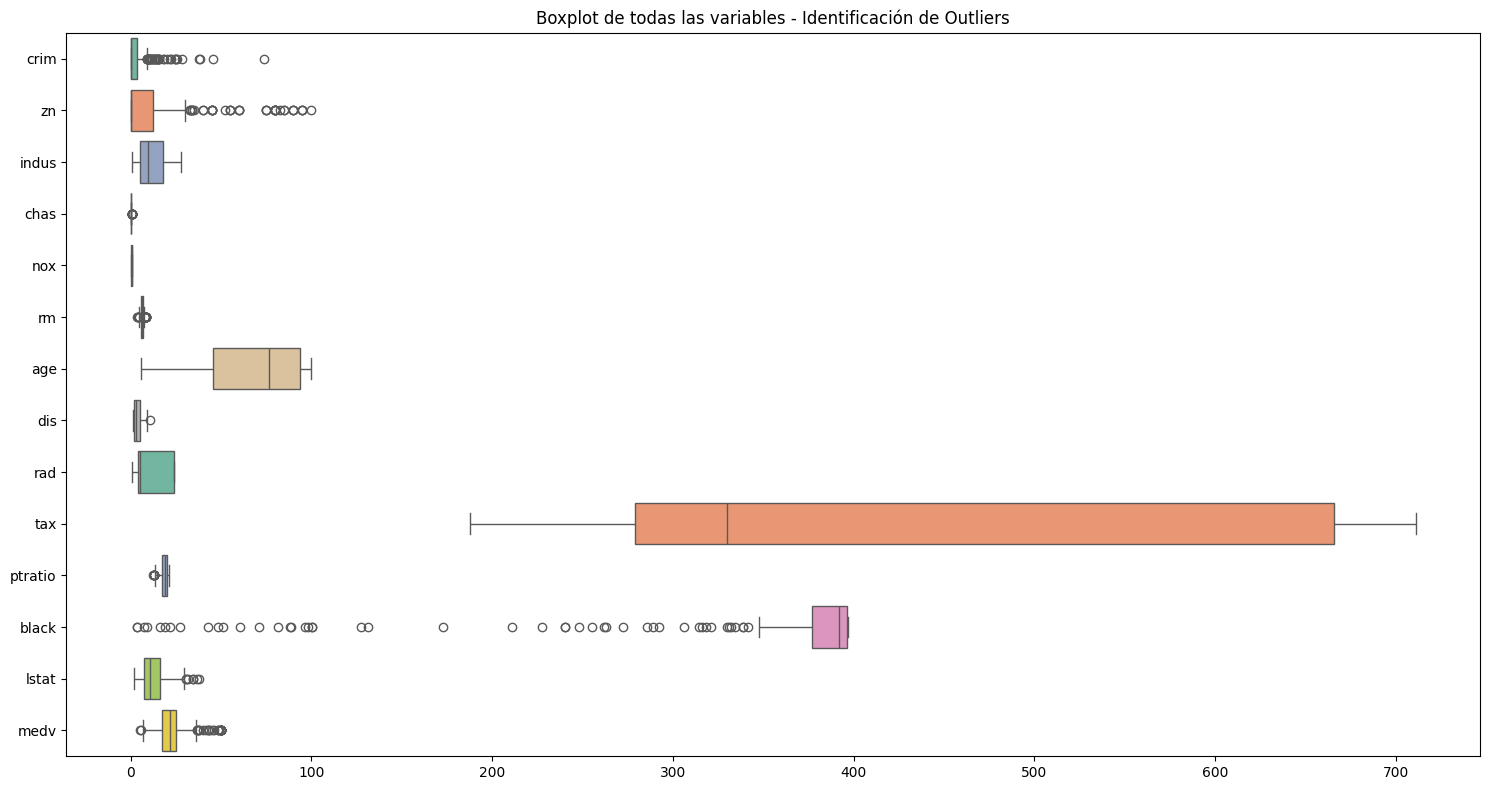

In [180]:
# Identificación de valores atípicos (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers
outliers_iqr = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))

# Contar cuántos outliers hay por columna
outliers_count = outliers_iqr.sum()

# Gráfico de boxplot para identificar visualmente los outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, orient="h", palette="Set2")
plt.title("Boxplot de todas las variables - Identificación de Outliers")
plt.tight_layout()
plt.show()

In [181]:
# Reemplazo de valores atípicos con el límite superior/inferior aceptado (Winsorización)
df_sin_outliers = df.copy()
for col in df.columns:
    if df[col].dtype != 'object':
        lower = Q1[col] - 1.5 * IQR[col]
        upper = Q3[col] + 1.5 * IQR[col]
        df_sin_outliers[col] = np.where(df[col] < lower, lower,
                                        np.where(df[col] > upper, upper, df[col]))

In [182]:
# Aplicar el modelo optimizado con los datos corregidos
# Preparar los datos
X_clean = df_sin_outliers[['lstat', 'rm', 'dis', 'crim', 'nox']]
y_clean = df_sin_outliers['medv']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

In [183]:
# Reentrenar con el mismo mejor modelo (parámetros obtenidos previamente)
mejor_modelo.fit(X_train_clean, y_train_clean)
y_pred_clean = mejor_modelo.predict(X_test_clean)

In [184]:
# Evaluación
mae_clean = mean_absolute_error(y_test_clean, y_pred_clean)
rmse_clean = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
mape_clean = np.mean(np.abs((y_test_clean - y_pred_clean) / y_test_clean)) * 100
r2_clean = r2_score(y_test_clean, y_pred_clean)

In [185]:
# Métricas después de tratar outliers
metricas_outliers = pd.DataFrame({
    "Métrica": ["MAE", "RMSE", "MAPE", "R^2"],
    "Valor (con outliers tratados)": [mae_clean, rmse_clean, mape_clean, r2_clean]
})

metricas_outliers

,Métrica,Valor (con outliers tratados)
0,MAE,2.318569
1,RMSE,3.128344
2,MAPE,13.534302
3,R^2,0.831975
